In [1]:
using Revise
using GLMakie
using Arya

[ Info: Precompiling Arya [415bc928-4679-4905-9aff-233f9524af88]
[ Info: Precompiling AryaMeasurementsExt [2f77244d-f0f4-5d92-99ae-56f9b7abc771]


In [2]:
import DensityEstimators as DE

In this notebook, I investigate some methods for calculating the density :)

In [3]:
import Distributions: Normal

In [4]:
using Optim

In [5]:
import StatsBase: quantile

# Distributions

In [6]:
dist_normal = Normal(1, π/2)

Normal{Float64}(μ=1.0, σ=1.5707963267948966)

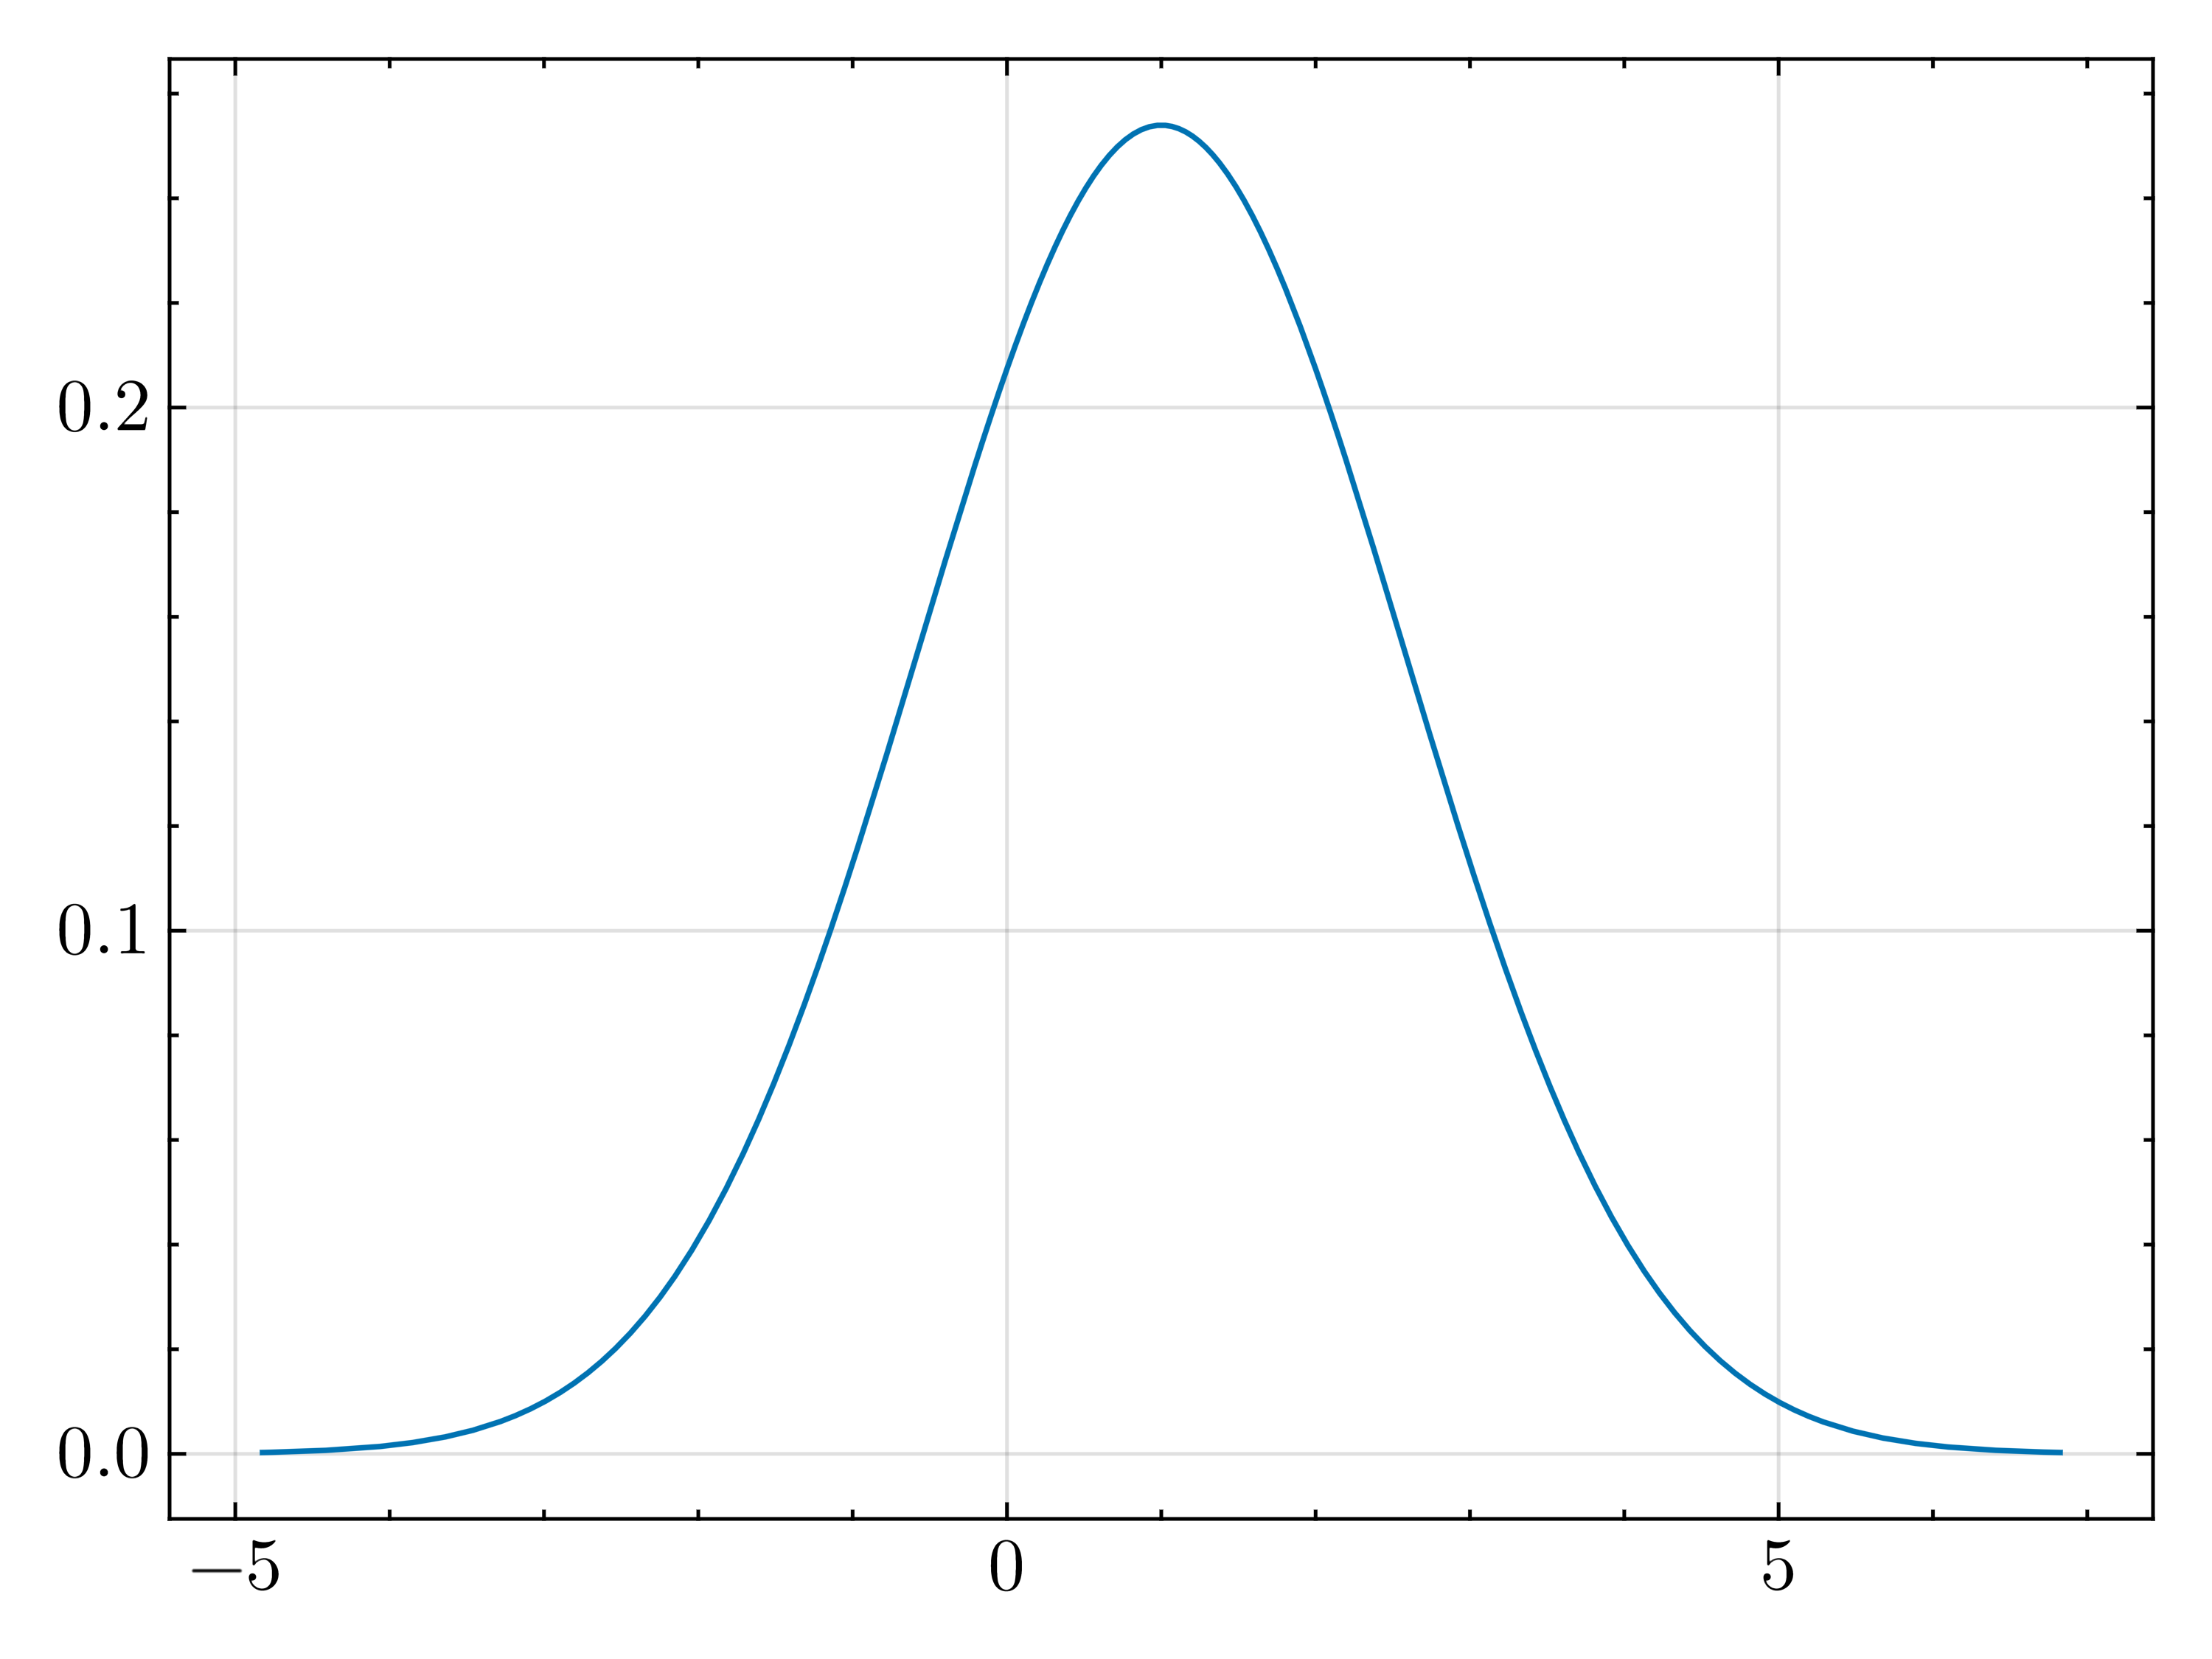

In [7]:
plot(dist_normal)

# BSpline

In [613]:
N = 100
x = rand(dist_normal, N);

## Primal spline

In [626]:
Nk = 5
k_0 = LinRange(minimum(x), maximum(x), Nk)
#k_0 = quantile(x, LinRange(0, 1, Nk));

degree = 3

3

In [627]:
s = DE.PrimalBSpline(x, k_0, degree=degree)

DensityEstimators.BSpline(7-element Spline{Float64}:
 basis: 7-element BSplineBasis of order 4, domain [-3.5926154027225112, 6.585023989173343]
 order: 4
 knots: [-3.59262, -3.59262, -3.59262, -3.59262, -1.04821, 1.4962, 4.04061, 6.58502, 6.58502, 6.58502, 6.58502]
 coefficients: [0.00165029, 0.0253304, 0.140761, 0.209381, 0.0785583, 0.0117269, 0.000824615])

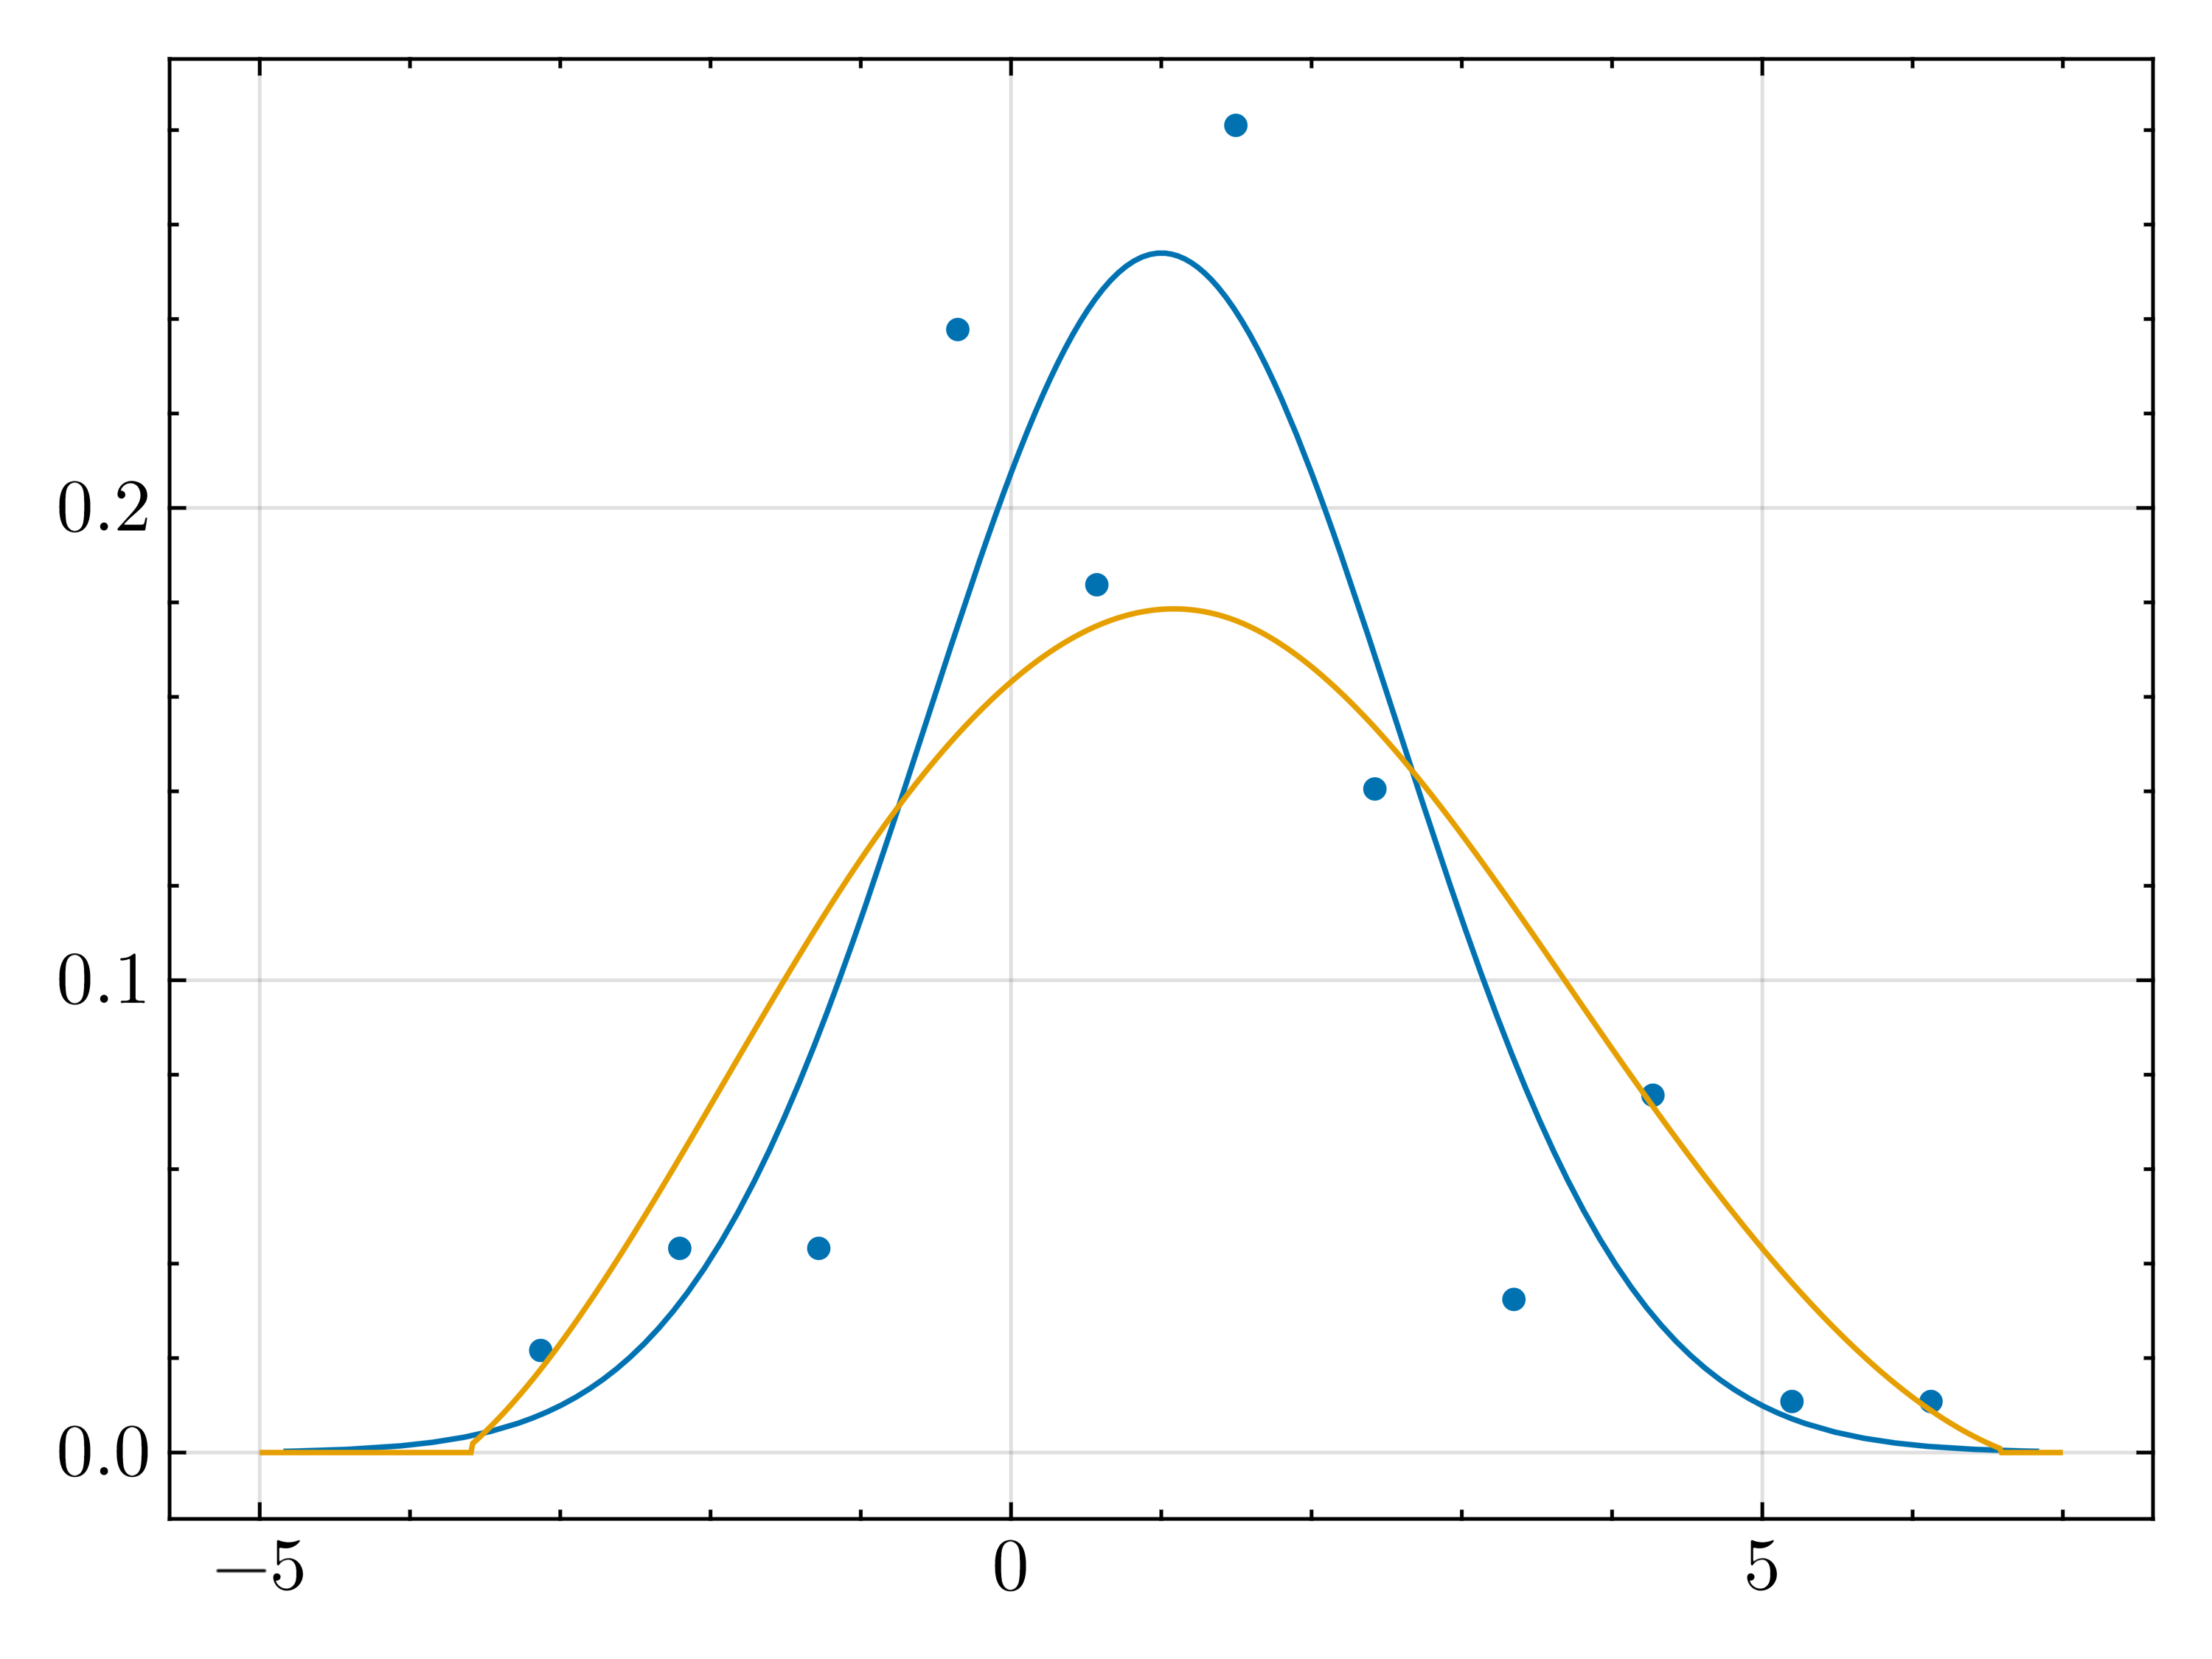

In [628]:
fig, ax = FigAxis()

h = DE.histogram(x, normalization=:pdf)
plot!(midpoints(h.bins), h.values)

plot!(dist_normal)

x_m = LinRange(-5, 7, 1000)
y = s.(x_m)
lines!(x_m, y)

fig

### Series approximated duals

In [612]:
function log_L(spline, x; s=0.0)
    
    N = length(x)
    s_x = spline.(x)
    if any(s_x .< 0)
        return -Inf
    end
    
    A = DE.integral(spline)(spline.knots[end])
    return 1/N * sum(log.(s_x)) - 3abs.(log.(A)) # constraint
end

log_L (generic function with 2 methods)

In [176]:
function optimize_spline(knots, coef_i, order, samples)
    
    function obj(coef)
        s = DE.BSpline(knots, coef, order)
        -log_L(s, samples)
    end
    
    result = optimize(obj, coef_i)
    
    return result.minimizer, result
end

optimize_spline (generic function with 1 method)

In [177]:
Nk = 5
k_0 = quantile(x, LinRange(0, 1, Nk))
a_0 = 1/Nk * rand(length(k_0) + 1)
c0_0 = 1

1

In [178]:

a, result = optimize_spline(k_0, a_0, 3, x)


([0.00957773348663311, -0.04192725579915486, 0.23418044502328939, 0.25014862476356203, -0.038797011696549644, 0.007870189588912634],  * Status: success

 * Candidate solution
    Final objective value:     1.875069e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    745
    f(x) calls:    1206
)

In [179]:
h = DE.histogram(x, normalization=:pdf)
length(h.bins), length(h.values)

(62, 61)

In [180]:
s_best = DE.BSpline(k_0, a, 3)

DensityEstimators.BSpline(6-element Spline{Float64}:
 basis: 6-element BSplineBasis of order 3, domain [-5.158334951218719, 6.766940198387718]
 order: 3
 knots: [-5.15833, -5.15833, -5.15833, -0.0466391, 1.03264, 2.06548, 6.76694, 6.76694, 6.76694]
 coefficients: [0.00957773, -0.0419273, 0.23418, 0.250149, -0.038797, 0.00787019])

In [181]:
DE.integral(s_best)(k_0[end])

1.0000000090903223

In [182]:
minimum(s_best.(x))

9.139307679623454e-5

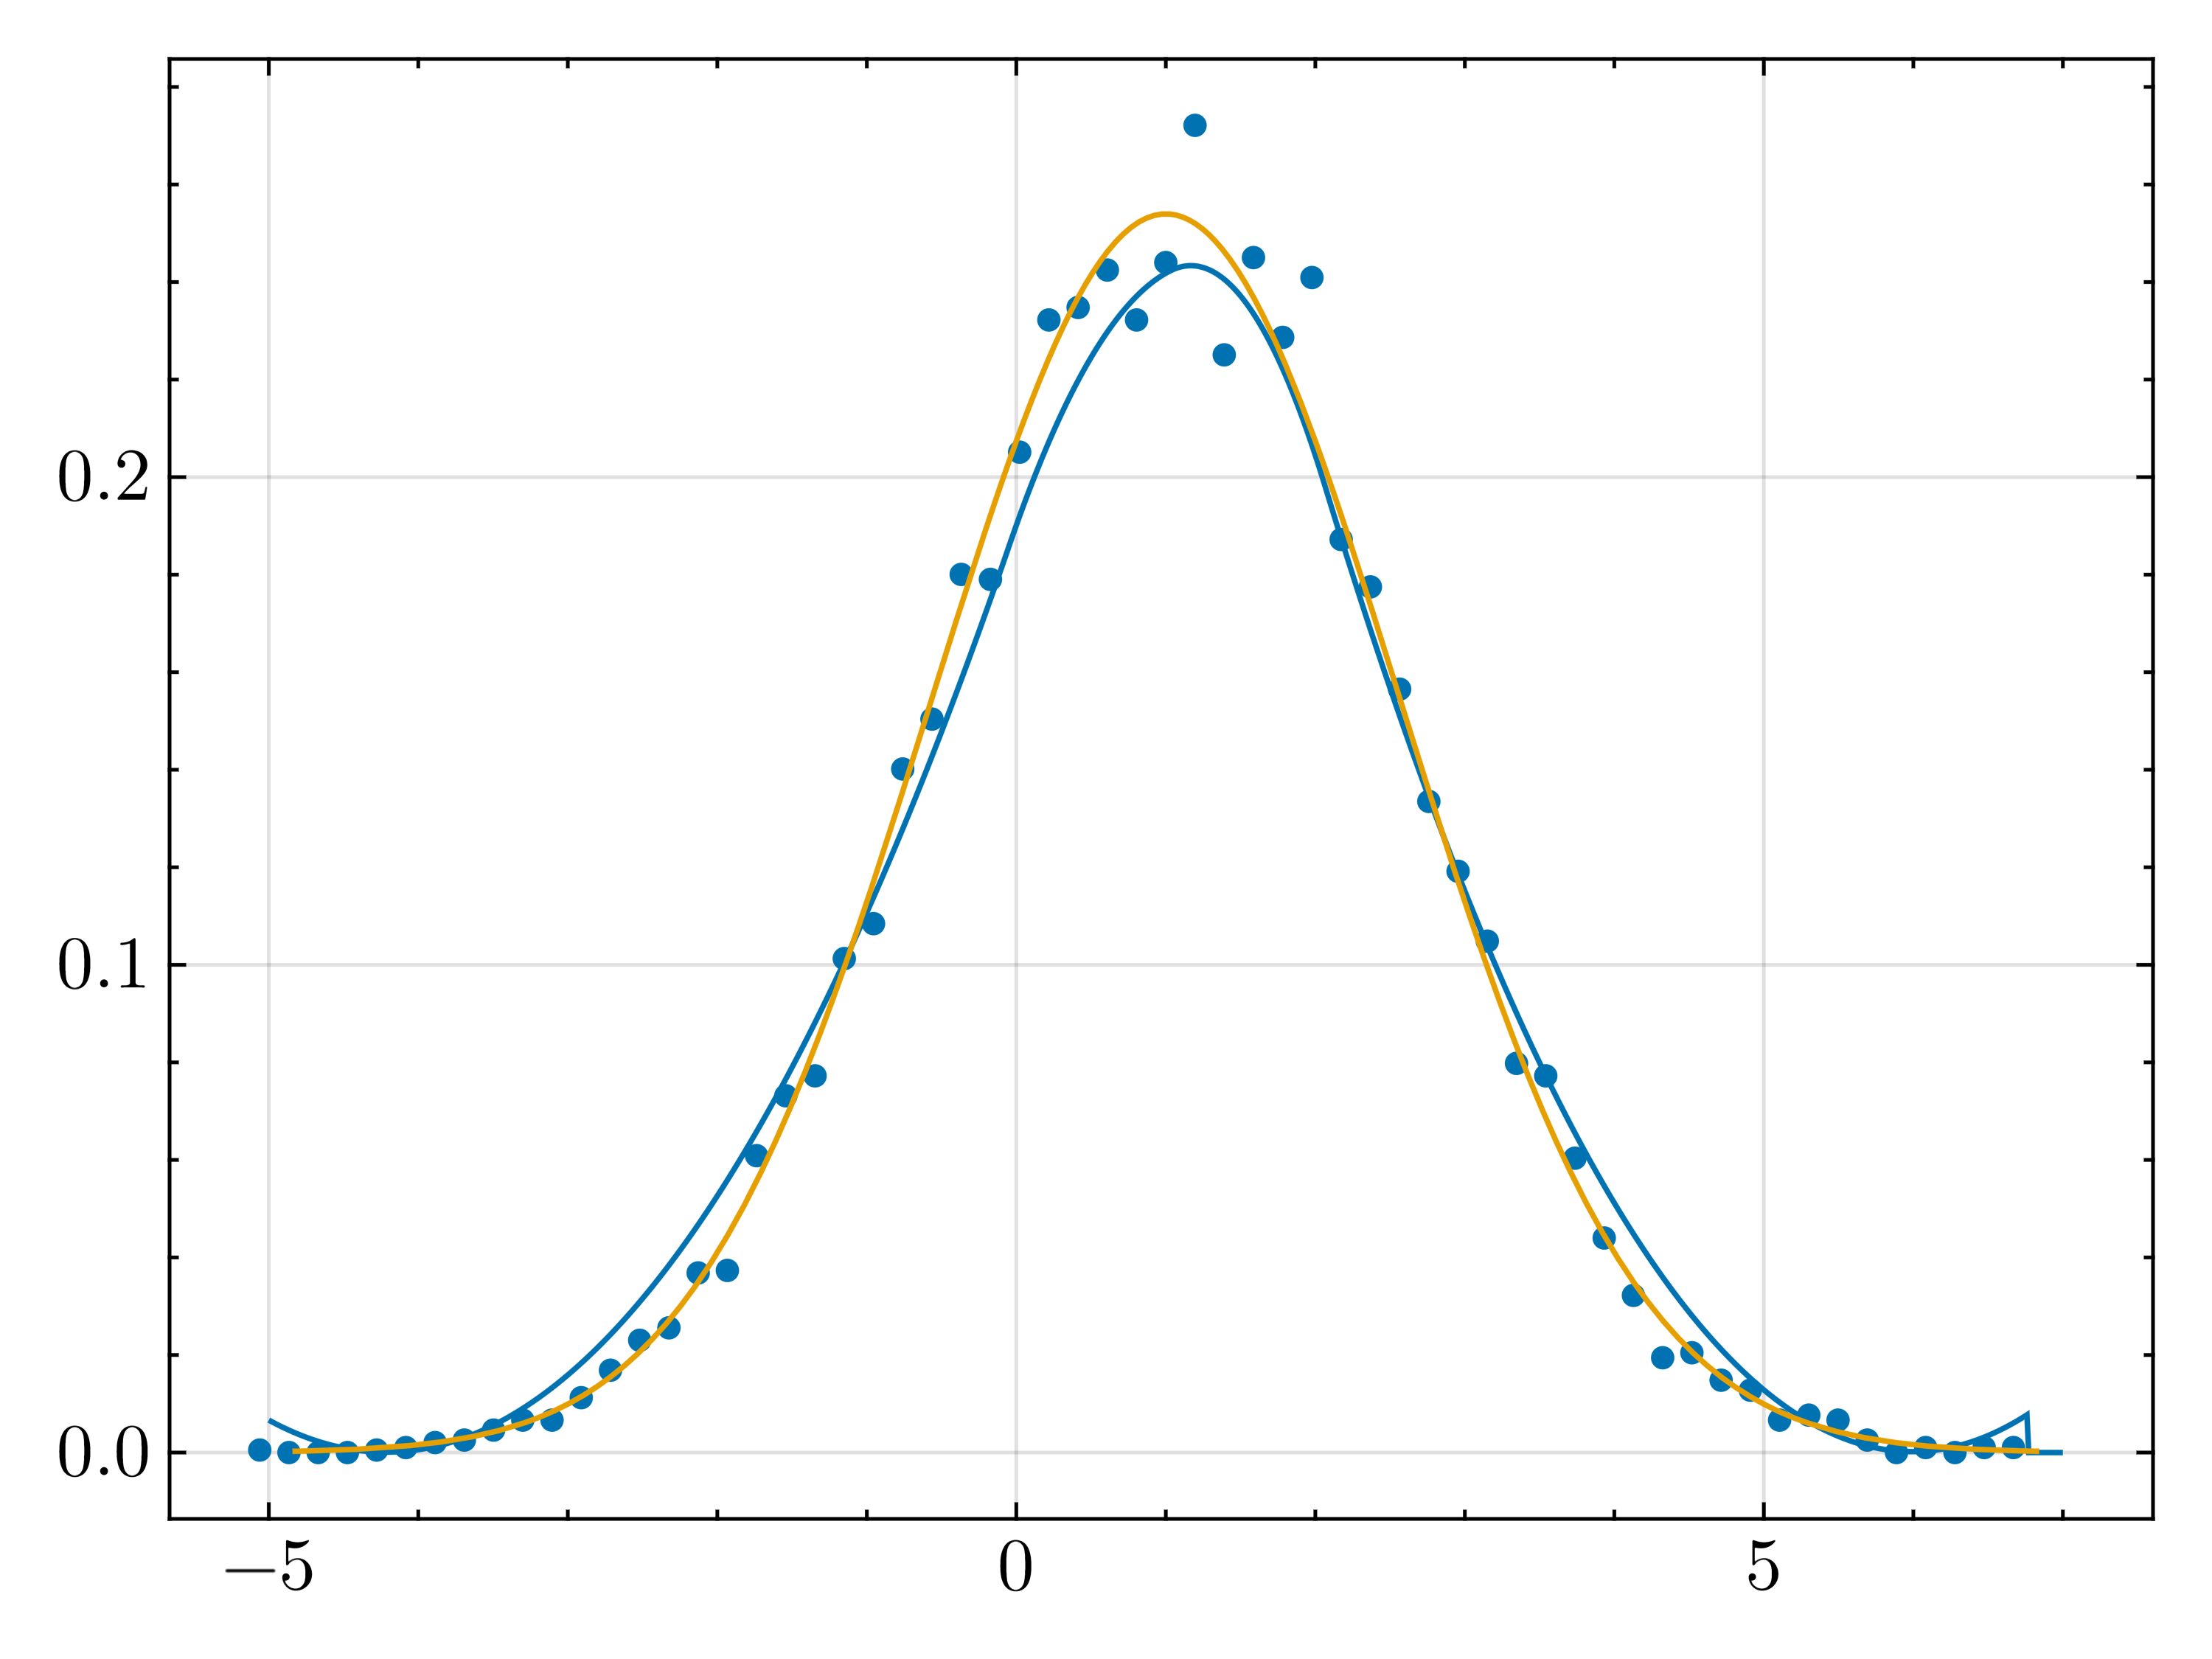

In [186]:
fig, ax = FigAxis()

h = DE.histogram(x, normalization=:pdf)
plot!(midpoints(h.bins), h.values)

x_m = LinRange(-5, 7, 1000)
y_m = s_best.(x_m)
lines!(x_m, y_m)
lines!(dist_normal, color=COLORS[2])

fig

# Log Splines

In [156]:
struct LogSpline
    knots::Vector{Float64}
    coef::Vector{Float64}
    order::Int
    _spline
end

In [157]:
function LogSpline(knots, coefs, order=3)
    s = DE.BSpline(knots, coefs[1:end-1], order)
    c0 = coefs[end]
    
    return LogSpline(knots, coefs, order, s)
end

LogSpline

In [159]:
import QuadGK: quadgk

In [160]:
function log_L(spline::LogSpline, x; s=0.0)
    N = length(x)
    s_x = spline.(x)
    if any(s_x .< 0)
        return -Inf
    end
    
    A = quadgk(spline, spline.knots[1], spline.knots[end])[1]
    
    return 1/N * sum(log.(s_x)) - 3abs.(log.(A)) # constraint
end

log_L (generic function with 2 methods)

In [170]:
function optimize_lspline(knots, coef_i, order, samples)
    
    function obj(coef)
        s = LogSpline(knots, coef, order)
        -log_L(s, samples)
    end
    
    result = optimize(obj, coef_i)
    
    return result.minimizer, result
end

optimize_lspline (generic function with 1 method)

In [164]:
function (s::LogSpline)(x)
    c0 = s.coef[end]
    return c0 .+ exp.(s._spline(x))
end

In [165]:
k_0

5-element Vector{Float64}:
 -5.158334951218719
 -0.04663912842891936
  1.032642744205156
  2.0654835191994096
  6.766940198387718

In [171]:
a, res = optimize_lspline(k_0, [a; 0], 3, x)

([0.07300197848409, 0.0016653029591037305, 0.27372715191691416, 0.2726062978146186, 0.016620406627027358, 0.06637938445864958, -1.0572333481301401],  * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.882535e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   4  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    1606
)

In [172]:
s_best = LogSpline(k_0, a, 3)

LogSpline([-5.158334951218719, -0.04663912842891936, 1.032642744205156, 2.0654835191994096, 6.766940198387718], [0.07300197848409, 0.0016653029591037305, 0.27372715191691416, 0.2726062978146186, 0.016620406627027358, 0.06637938445864958, -1.0572333481301401], 3, DensityEstimators.BSpline(6-element Spline{Float64}:
 basis: 6-element BSplineBasis of order 3, domain [-5.158334951218719, 6.766940198387718]
 order: 3
 knots: [-5.15833, -5.15833, -5.15833, -0.0466391, 1.03264, 2.06548, 6.76694, 6.76694, 6.76694]
 coefficients: [0.073002, 0.0016653, 0.273727, 0.272606, 0.0166204, 0.0663794]))

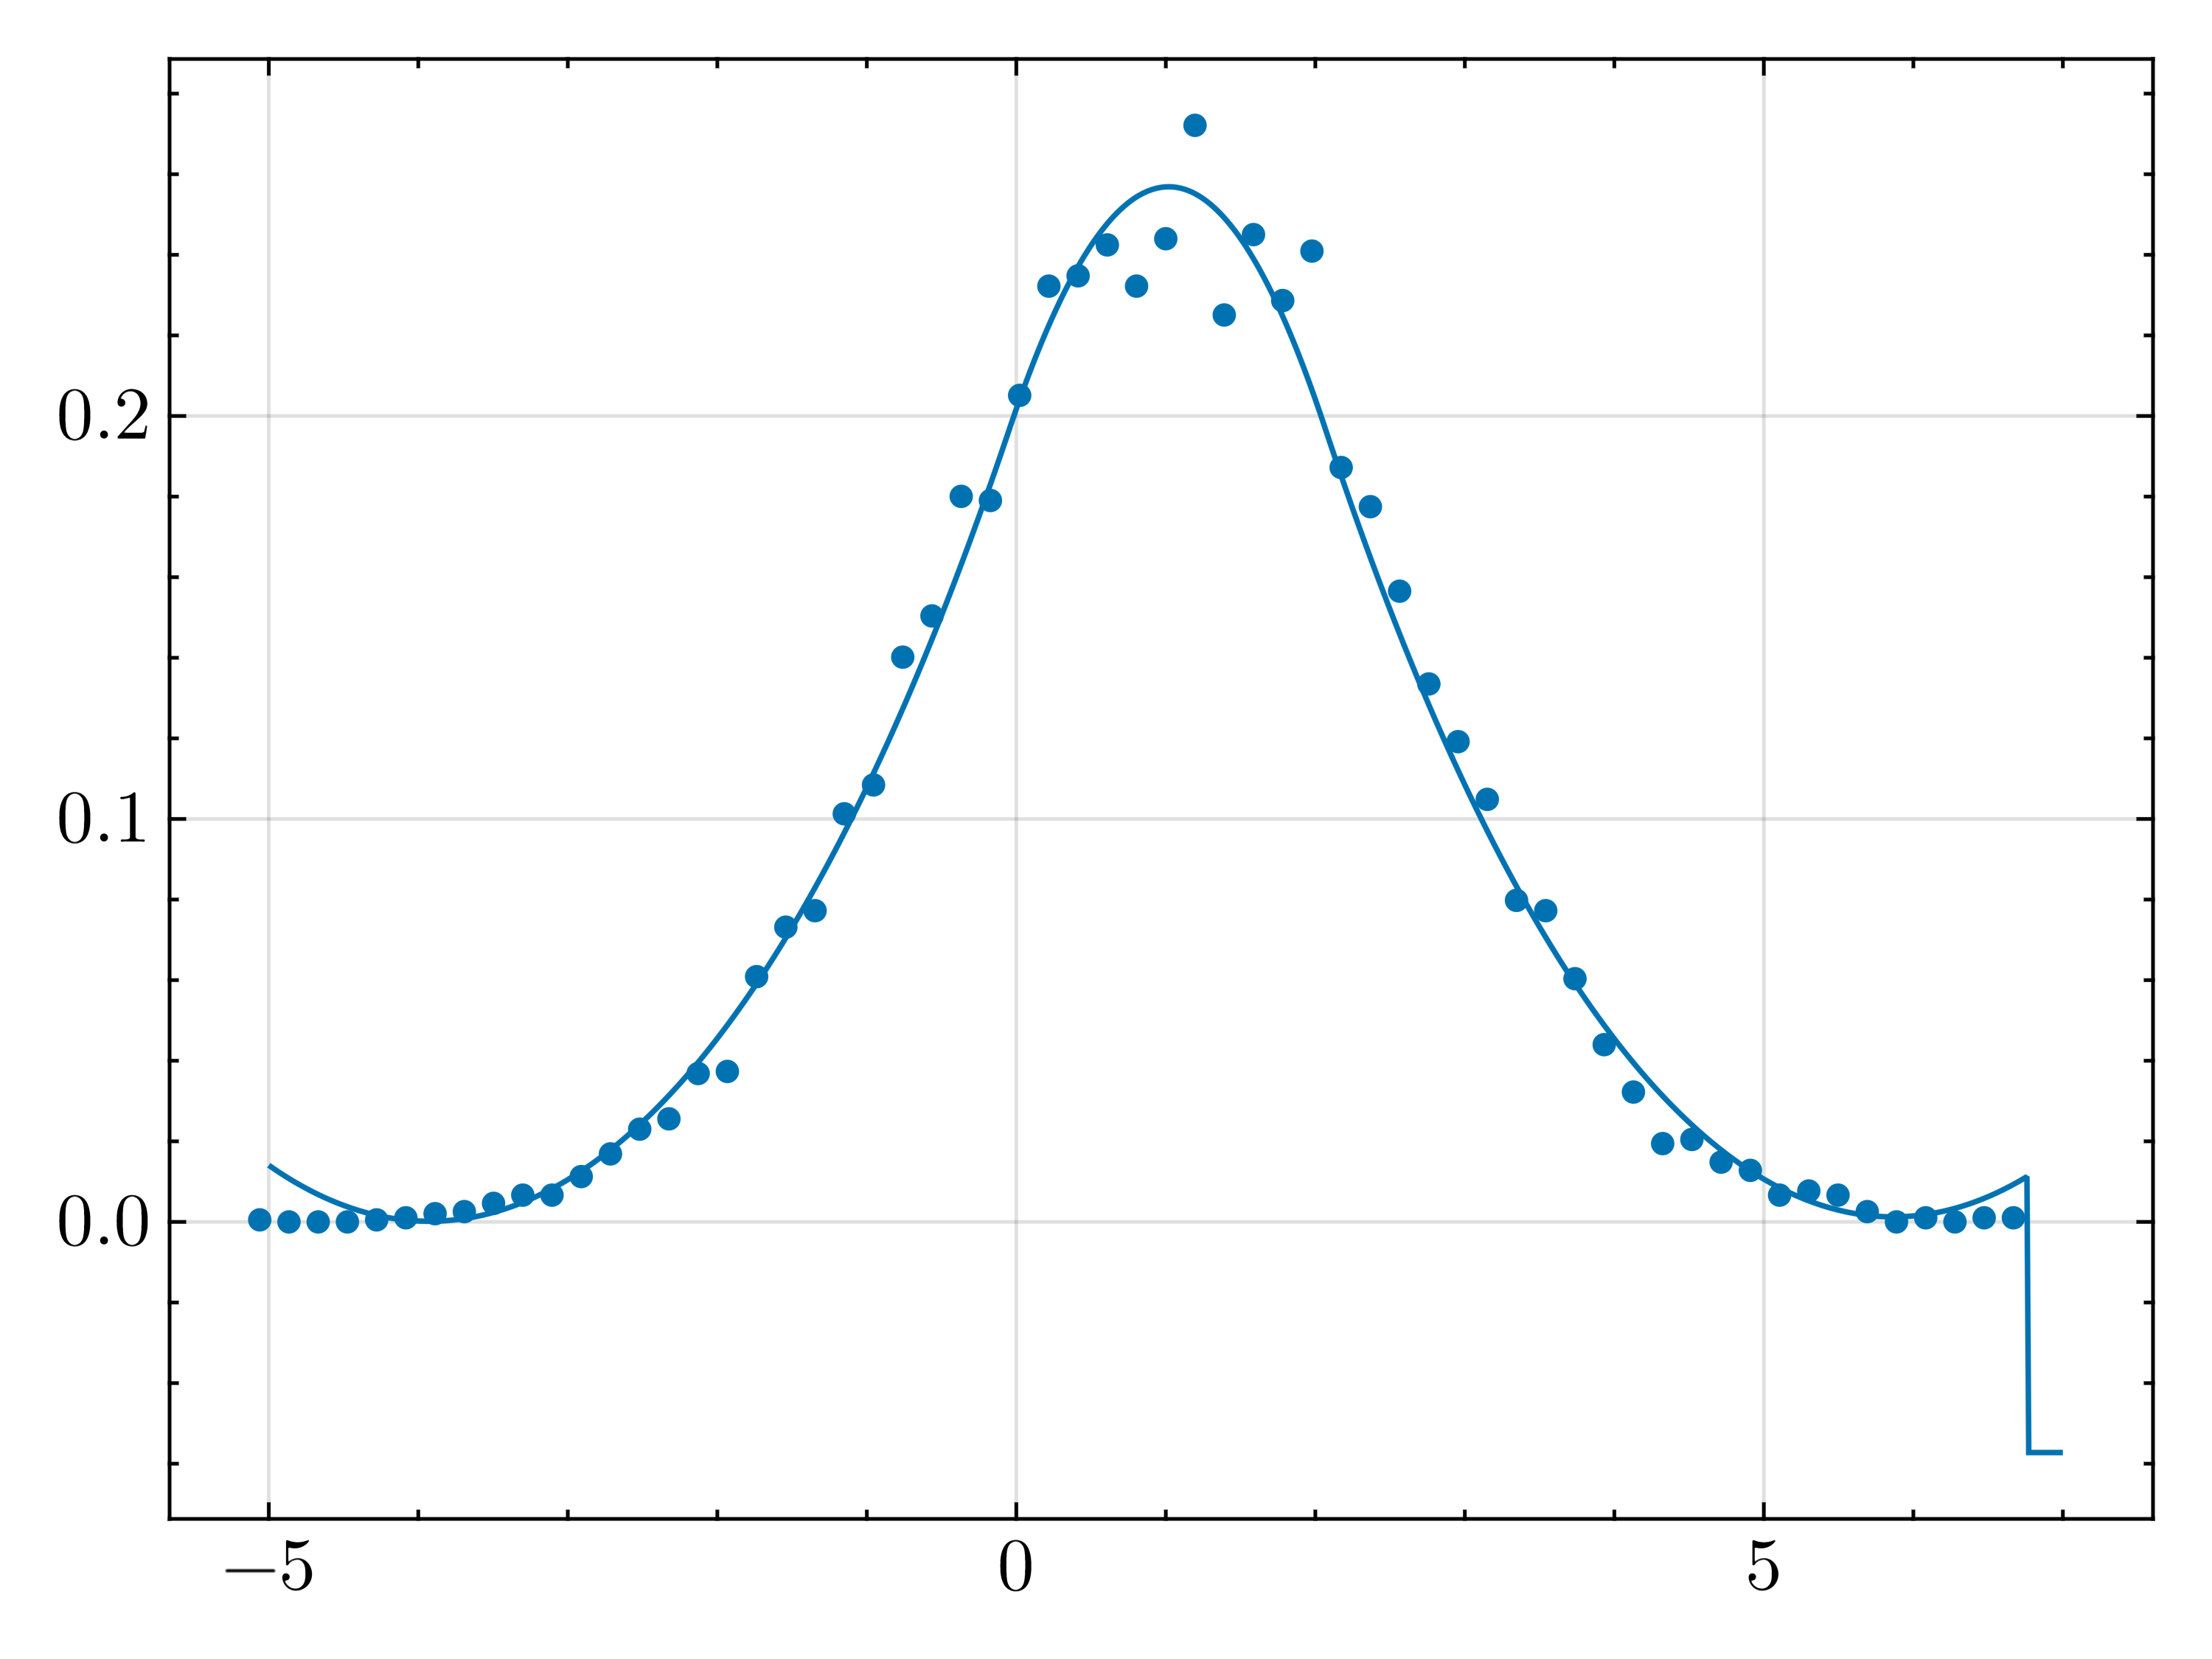

In [173]:
fig, ax = FigAxis()

h = DE.histogram(x, normalization=:pdf)
x_m = LinRange(-5, 7, 1000)
y_m = s_best.(x_m)
lines!(x_m, y_m)

plot!(midpoints(h.bins), h.values)
fig

In [ ]:
fig, ax = FigAxis()

h = DE.histogram(x, normalization=:pdf)
x_m = LinRange(-5, 7, 1000)
y_m = s_best.(x_m)
lines!(x_m, y_m)

plot!(midpoints(h.bins), h.values)
fig